# **PARKINSON'S DISEASE detection AND The Unified Parkinson's Disease Rating Scale (UPDRS) prediction using Machine Learning Methods**

UPDRS - The Unified Parkinson's Disease Rating Scale (UPDRS) is a tool used to assess the progression and severity of Parkinson's disease (PD). It is the most common scale used in clinical studies of PD.

The modified UPDRS retains the four-scale structure with a reorganization of the various subscales. Score ranges from 0 to 260, with 0 indicating no disability and 260 indicating total disability. The scales are:

* Part I: Nonmotor experiences of daily living: 13 items. Score range: 0 - 52, 10 and below is mild, 22 and above is severe.

* Part II: Motor experiences of daily living: 13 items. Score range: 0 - 52, 12 and below is mild, 30 and above is severe.

* Part III: Motor examination: 18 items. Score range: 0 - 132, 32 and below is mild, 59 and above is severe.

* Part IV: Motor complications: 6 items. Score range: 0 - 24, 4 and below is mild, 13 and above is severe.

As we are making use of voice samples to detect the presence of PD, our analysis comes under the PART-I of the scales.

## Importing necessary libaries

In [ ]:
# **Install Missing Packages**
!pip install librosa numpy scipy praat-parselmouth nolds

# **Standard Libraries**
import random
import numpy as np
import pandas as pd
from scipy.stats import t, norm, entropy

# **Visualization Libraries**
import seaborn as sns
import matplotlib.pyplot as plt

# **Audio Processing Libraries**
import librosa
import librosa.display
import parselmouth
from parselmouth.praat import call

# **Machine Learning Libraries**
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# **Deep Learning Libraries**
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GRU, Attention, Dropout,
    GlobalAveragePooling1D, BatchNormalization, Bidirectional, MultiHeadAttention
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.utils import plot_model

# **Boosting Libraries**
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# **Time-Series Analysis Libraries**
import nolds

# **Google Colab Specific**
from google.colab import drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 9.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Importing Dataset for PD Detection
### [Multiple Sound Recording (MSR) Dataset](https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings)
The training data were gathered from 20 patients with Parkinsons and 20 health individuals. Multiple types of sound recordings were taken from each participant (listed below) and expert physicians assigned each participant a Unified Parkinsonâ€™s Disease Rating Scale (UPDRS) score.

Utterances
- 1: sustained vowel (aaaâ€¦â€¦)
- 2: sustained vowel (oooâ€¦...)
- 3: sustained vowel (uuuâ€¦...)
- 4-13: numbers from 1 to 10
- 14-17: short sentences
- 18-26: words

Features
Training Data File:
- column 1: Subject id

- columns 2-27: features
- features 1-5: Jitter (local),Jitter (local, absolute),Jitter (rap),Jitter (ppq5),Jitter (ddp),
- features 6-11: Shimmer (local),Shimmer (local, dB),Shimmer (apq3),Shimmer (apq5), Shimmer (apq11),Shimmer (dda),
- features 12-14: AC,NTH,HTN,
- features 15-19: Median pitch,Mean pitch,Standard deviation,Minimum pitch,Maximum pitch,
- features 20-23: Number of pulses,Number of periods,Mean period,Standard deviation of period, features 24-26: Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks

- column 28: UPDRS
- column 29: class information

The testing data were gathered from 28 different patients with Parkinsons. The patients are asked to speak producing 168 recordings. The same 26 features are extracted from the voice samples.



In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Parkinsons_final_yr/MSR_Data.csv')

Mounted at /content/drive


In [ ]:
# finding number of rows and columns
df.shape

(1040, 29)

In [ ]:
#Show first 5 rows of the dataset
df.head()

,subject_id,jitter_local,jitter_local_absolute,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_db,shimmer_apq3,shimmer_apq5,...,max_pitch,num_pulses,num_periods,mean_period,standard_dev_period,frac_locally_unvoiced_frames,num_voice_breaks,degree_of_voice_breaks,UPDRS,class_info
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


In [ ]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subject_id                    1040 non-null   int64  
 1   jitter_local                  1040 non-null   float64
 2   jitter_local_absolute         1040 non-null   float64
 3   jitter_rap                    1040 non-null   float64
 4   jitter_ppq5                   1040 non-null   float64
 5   jitter_ddp                    1040 non-null   float64
 6   shimmer_local                 1040 non-null   float64
 7   shimmer_local_db              1040 non-null   float64
 8   shimmer_apq3                  1040 non-null   float64
 9   shimmer_apq5                  1040 non-null   float64
 10  shimmer_apq11                 1040 non-null   float64
 11  shimmer_data                  1040 non-null   float64
 12  AC                            1040 non-null   float64
 13  NTH

In [ ]:
# Check for any missing values in the entire dataset
print(df.isnull().sum().sum())

0


In [ ]:
# Check for duplicate rows in the dataset
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


In [ ]:
new_column_names = [
    "Subject_ID", "Jitter(%)", "Jitter(Abs)", "Jitter(RAP)", "Jitter(PPQ5)",
    "Jitter(DDP)", "Shimmer(%)", "Shimmer(Abs)", "Shimmer(APQ3)", "Shimmer(APQ5)",
    "Shimmer(APQ11)", "Shimmer(DD)", "Harmonicity", "NHR", "HNR",
    "MedianPitch", "MeanPitch", "StdDevPitch", "MinPitch", "MaxPitch",
    "NumPulses", "NumPeriods", "MeanPeriod", "StdDevPeriod",
    "FractionUnvoicedFrames", "NumVoiceBreaks", "DegreeVoiceBreaks",
    "UPDRS", "PD Indicator"
]
# Rename the columns using the new names
df.columns = new_column_names
# Display the updated column names
print(df.columns)
df.head()

Index(['Subject_ID', 'Jitter(%)', 'Jitter(Abs)', 'Jitter(RAP)', 'Jitter(PPQ5)',
       'Jitter(DDP)', 'Shimmer(%)', 'Shimmer(Abs)', 'Shimmer(APQ3)',
       'Shimmer(APQ5)', 'Shimmer(APQ11)', 'Shimmer(DD)', 'Harmonicity', 'NHR',
       'HNR', 'MedianPitch', 'MeanPitch', 'StdDevPitch', 'MinPitch',
       'MaxPitch', 'NumPulses', 'NumPeriods', 'MeanPeriod', 'StdDevPeriod',
       'FractionUnvoicedFrames', 'NumVoiceBreaks', 'DegreeVoiceBreaks',
       'UPDRS', 'PD Indicator'],
      dtype='object')


,Subject_ID,Jitter(%),Jitter(Abs),Jitter(RAP),Jitter(PPQ5),Jitter(DDP),Shimmer(%),Shimmer(Abs),Shimmer(APQ3),Shimmer(APQ5),...,MaxPitch,NumPulses,NumPeriods,MeanPeriod,StdDevPeriod,FractionUnvoicedFrames,NumVoiceBreaks,DegreeVoiceBreaks,UPDRS,PD Indicator
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


<ipython-input-18-d3ea72801c3b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PD Indicator', data=df, palette=["#1f77b4", "#ff7f0e"])


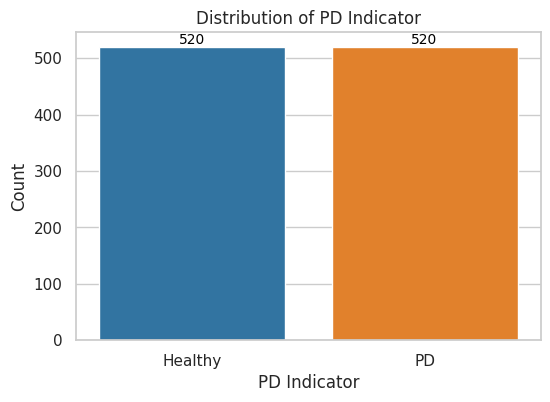

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

ax = sns.countplot(x='PD Indicator', data=df, palette=["#1f77b4", "#ff7f0e"])
plt.xlabel('PD Indicator')
plt.ylabel('Count')
plt.title('Distribution of PD Indicator')
plt.xticks([0, 1], ['Healthy', 'PD'])

# Adding integer count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [ ]:
df1 = df[df["PD Indicator"] == 0]
df2 = df[df["PD Indicator"] == 1]
print(df1)
print(df2)
df1.shape
df2.shape
# Calculate summary statistics for the DataFrame
df1.describe()
df2.describe()

      Subject_ID  Jitter(%)  Jitter(Abs)  Jitter(RAP)  Jitter(PPQ5)  \
520           21      0.792     0.000076        0.411         0.333   
521           21      0.400     0.000038        0.204         0.228   
522           21      0.813     0.000074        0.434         0.437   
523           21      1.700     0.000172        0.789         0.929   
524           21      1.528     0.000159        0.596         0.698   
...          ...        ...          ...          ...           ...   
1035          40      5.127     0.000398        2.721         2.510   
1036          40      1.757     0.000133        0.808         0.690   
1037          40      2.912     0.000226        1.141         1.266   
1038          40      3.788     0.000275        1.786         1.484   
1039          40      1.809     0.000149        0.680         0.843   

      Jitter(DDP)  Shimmer(%)  Shimmer(Abs)  Shimmer(APQ3)  Shimmer(APQ5)  \
520         1.234       4.136         0.391          2.202          2.

,Subject_ID,Jitter(%),Jitter(Abs),Jitter(RAP),Jitter(PPQ5),Jitter(DDP),Shimmer(%),Shimmer(Abs),Shimmer(APQ3),Shimmer(APQ5),...,MaxPitch,NumPulses,NumPeriods,MeanPeriod,StdDevPeriod,FractionUnvoicedFrames,NumVoiceBreaks,DegreeVoiceBreaks,UPDRS,PD Indicator
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,...,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.0
mean,10.500000,2.851624,0.000188,1.355861,1.474592,4.067577,12.967775,1.206312,5.644882,7.874292,...,217.941499,115.898077,113.003846,0.006700,0.000800,25.124183,1.005769,10.458273,25.000000,1.0
std,5.771834,1.680561,0.000113,0.917514,1.019404,2.752582,4.710492,0.365562,2.484632,3.513804,...,109.384758,178.532336,178.371805,0.001868,0.000736,20.661467,1.469656,13.762673,14.738308,0.0
min,1.000000,0.195000,0.000010,0.062000,0.091000,0.185000,2.171000,0.229000,0.565000,1.025000,...,85.541000,0.000000,0.000000,0.002211,0.000055,0.000000,0.000000,0.000000,5.000000,1.0
25%,5.750000,1.704500,0.000104,0.753250,0.800750,2.259250,10.140500,0.998500,3.990500,5.459500,...,141.537000,42.750000,41.000000,0.005085,0.000385,5.634000,0.000000,0.000000,11.750000,1.0
50%,10.500000,2.625500,0.000169,1.178500,1.255500,3.536000,12.805000,1.225500,5.262500,7.456000,...,187.379500,67.000000,65.000000,0.006668,0.000618,22.902000,1.000000,3.279500,23.500000,1.0
75%,15.250000,3.647250,0.000258,1.779750,1.930750,5.339750,15.332750,1.405250,6.807000,9.511810,...,243.293750,111.250000,109.000000,0.007986,0.000895,38.912500,1.000000,18.685000,34.000000,1.0
max,20.000000,10.439000,0.000713,6.125000,7.205000,18.375000,41.137000,2.689000,16.641000,31.750000,...,597.974000,1490.000000,1489.000000,0.012070,0.006371,88.158000,11.000000,60.298000,55.000000,1.0


In [ ]:
# Select the columns for comparison (excluding "Subject_ID" and "PD Indicator")
columns_to_compare = df1.columns.difference(["Subject_ID", "PD Indicator"])
# Calculate the differences between describe statistics for df2 and df1
differences = df2[columns_to_compare].describe() - df1[columns_to_compare].describe()
# Extract the desired statistics (mean, median, std, min, max) from the differences DataFrame
desired_statistics = ["mean", "50%", "std"]
differences = differences.loc[desired_statistics]
# Transpose the differences DataFrame for desired display format
differences = differences.transpose()
differences

# Display the differences
print("Differences between central tendencies of df2 and df1:")
print(differences)
# Calculate the absolute differences
absolute_differences = differences.abs()

# Sort the absolute differences DataFrame by mean values in descending order
sorted_absolute_differences = absolute_differences.sort_values(by=["mean"], ascending=False)

# Get the indices of the top 10 absolute differences
top_10_indices = sorted_absolute_differences.head(10).index

# Display the top 10 absolute differences with the original sign
print("Top 10 Absolute Differences between central tendencies \n of df2 and df1 by Mean:")
print(differences.loc[top_10_indices])

Differences between central tendencies of df2 and df1:
                             mean        50%        std
DegreeVoiceBreaks       -3.823538  -5.584000  -2.469251
FractionUnvoicedFrames  -5.117346  -7.090000  -0.332784
HNR                      0.347487   0.170000  -0.757765
Harmonicity              0.013894   0.002002  -0.021672
Jitter(%)                0.344203   0.411500  -0.150609
Jitter(Abs)              0.000036   0.000035   0.000017
Jitter(DDP)              0.652830   0.816000  -0.328866
Jitter(PPQ5)             0.252530   0.288000  -0.215438
Jitter(RAP)              0.217617   0.271500  -0.109611
MaxPitch               -33.868982 -14.685000 -21.127027
MeanPeriod               0.000307   0.000521  -0.000004
MeanPitch              -11.554505 -11.993000 -13.100106
MedianPitch             -9.431979  -9.436000 -16.751035
MinPitch                -5.559937  -4.403500  -7.879665
NHR                     -0.023007  -0.001509  -0.037954
NumPeriods              14.069231   6.500000  65.

In [ ]:
# Select numeric columns for histograms
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns

# Exclude specific columns
columns_to_exclude = ["Subject_ID", "PD Indicator"]
numeric_columns = numeric_columns.difference(columns_to_exclude)

# Set up the Seaborn style
sns.set(style="whitegrid")

# Define custom color palette for histograms
custom_color_palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Blue and orange

# Define hatch patterns for healthy and unhealthy individuals
hatch_patterns = ["", "////"]  # No hatch for healthy, hatch for unhealthy


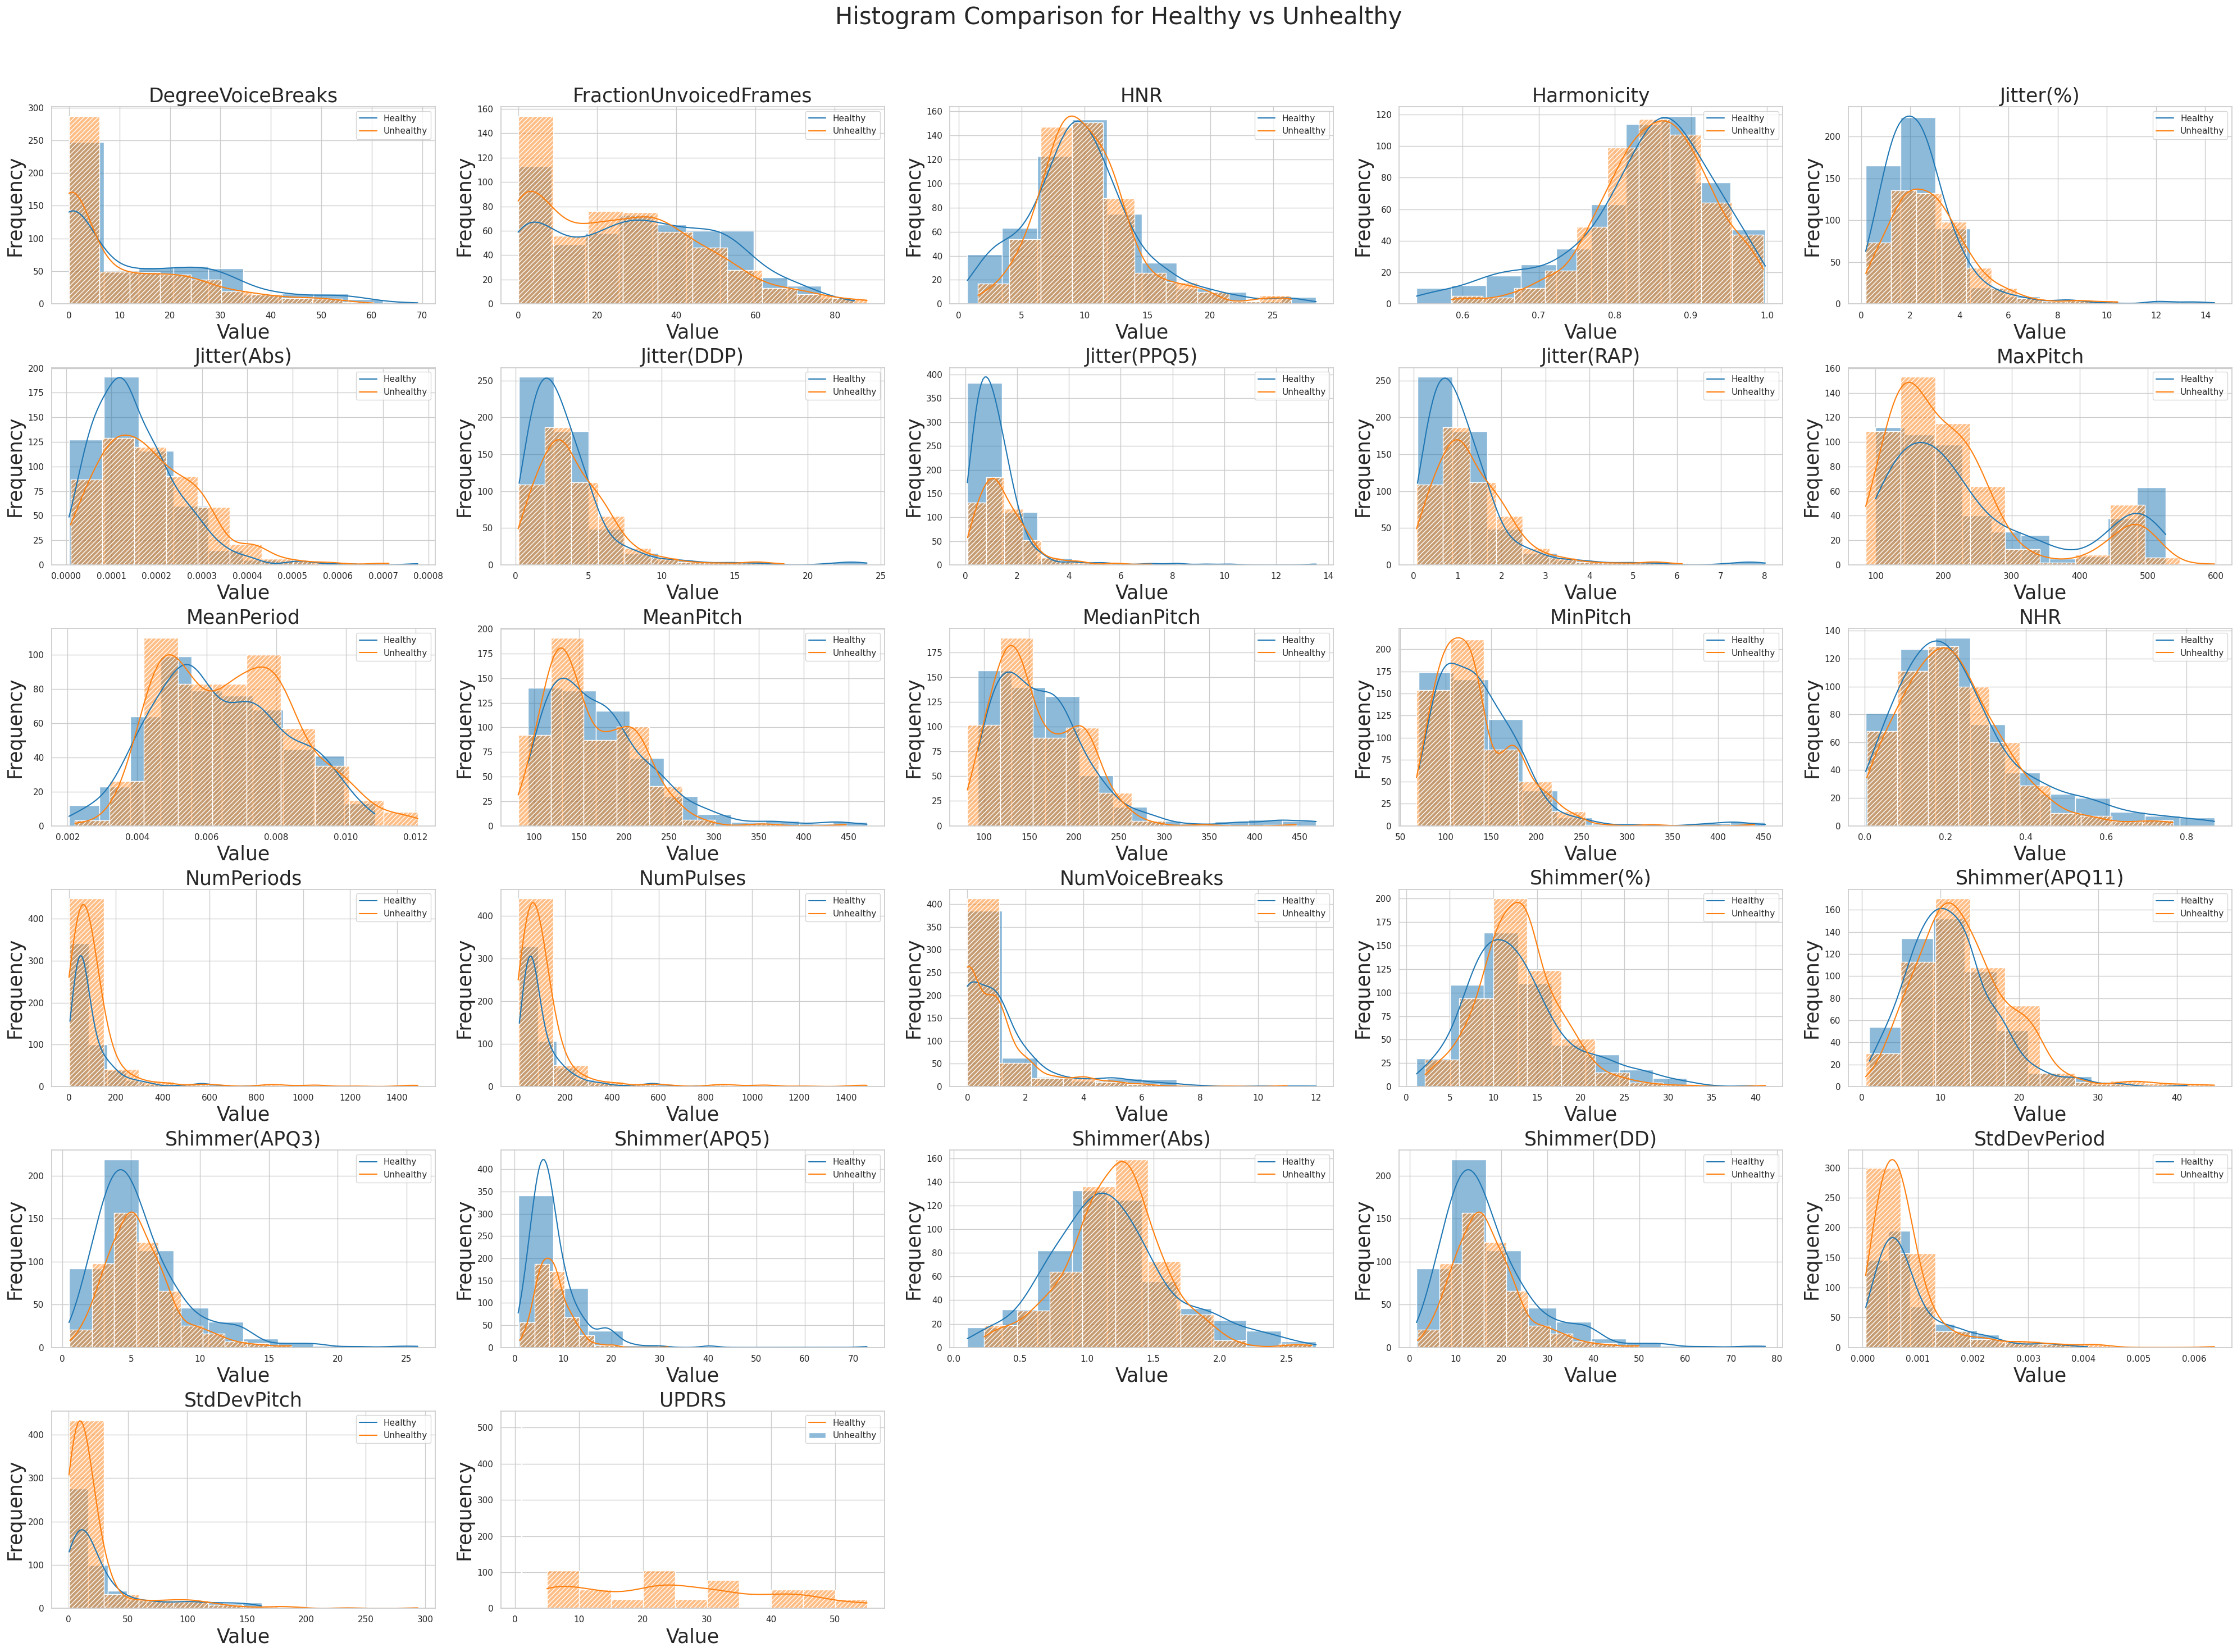

In [ ]:
def plot_side_by_side_histograms(dataframe1, dataframe2, title):
    plt.figure(figsize=(40, 30))
    for i, column in enumerate(numeric_columns, start=1):
        plt.subplot(6, 5, i)
        sns.histplot(dataframe1[column], bins=10, kde=True, color=custom_color_palette[0], hatch=hatch_patterns[0])
        sns.histplot(dataframe2[column], bins=10, kde=True, color=custom_color_palette[1], hatch=hatch_patterns[1])
        plt.title(column, fontsize=25)  # Set individual histogram title font size
        plt.xlabel("Value", fontsize=25)
        plt.ylabel("Frequency", fontsize=25)
        plt.legend(labels=["Healthy", "Unhealthy"])

    plt.tight_layout()
    plt.suptitle(f"Histogram Comparison for {title}", fontsize=30)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Plot side-by-side histograms for df1 (healthy) and df2 (unhealthy)
plot_side_by_side_histograms(df1, df2, "Healthy vs Unhealthy")

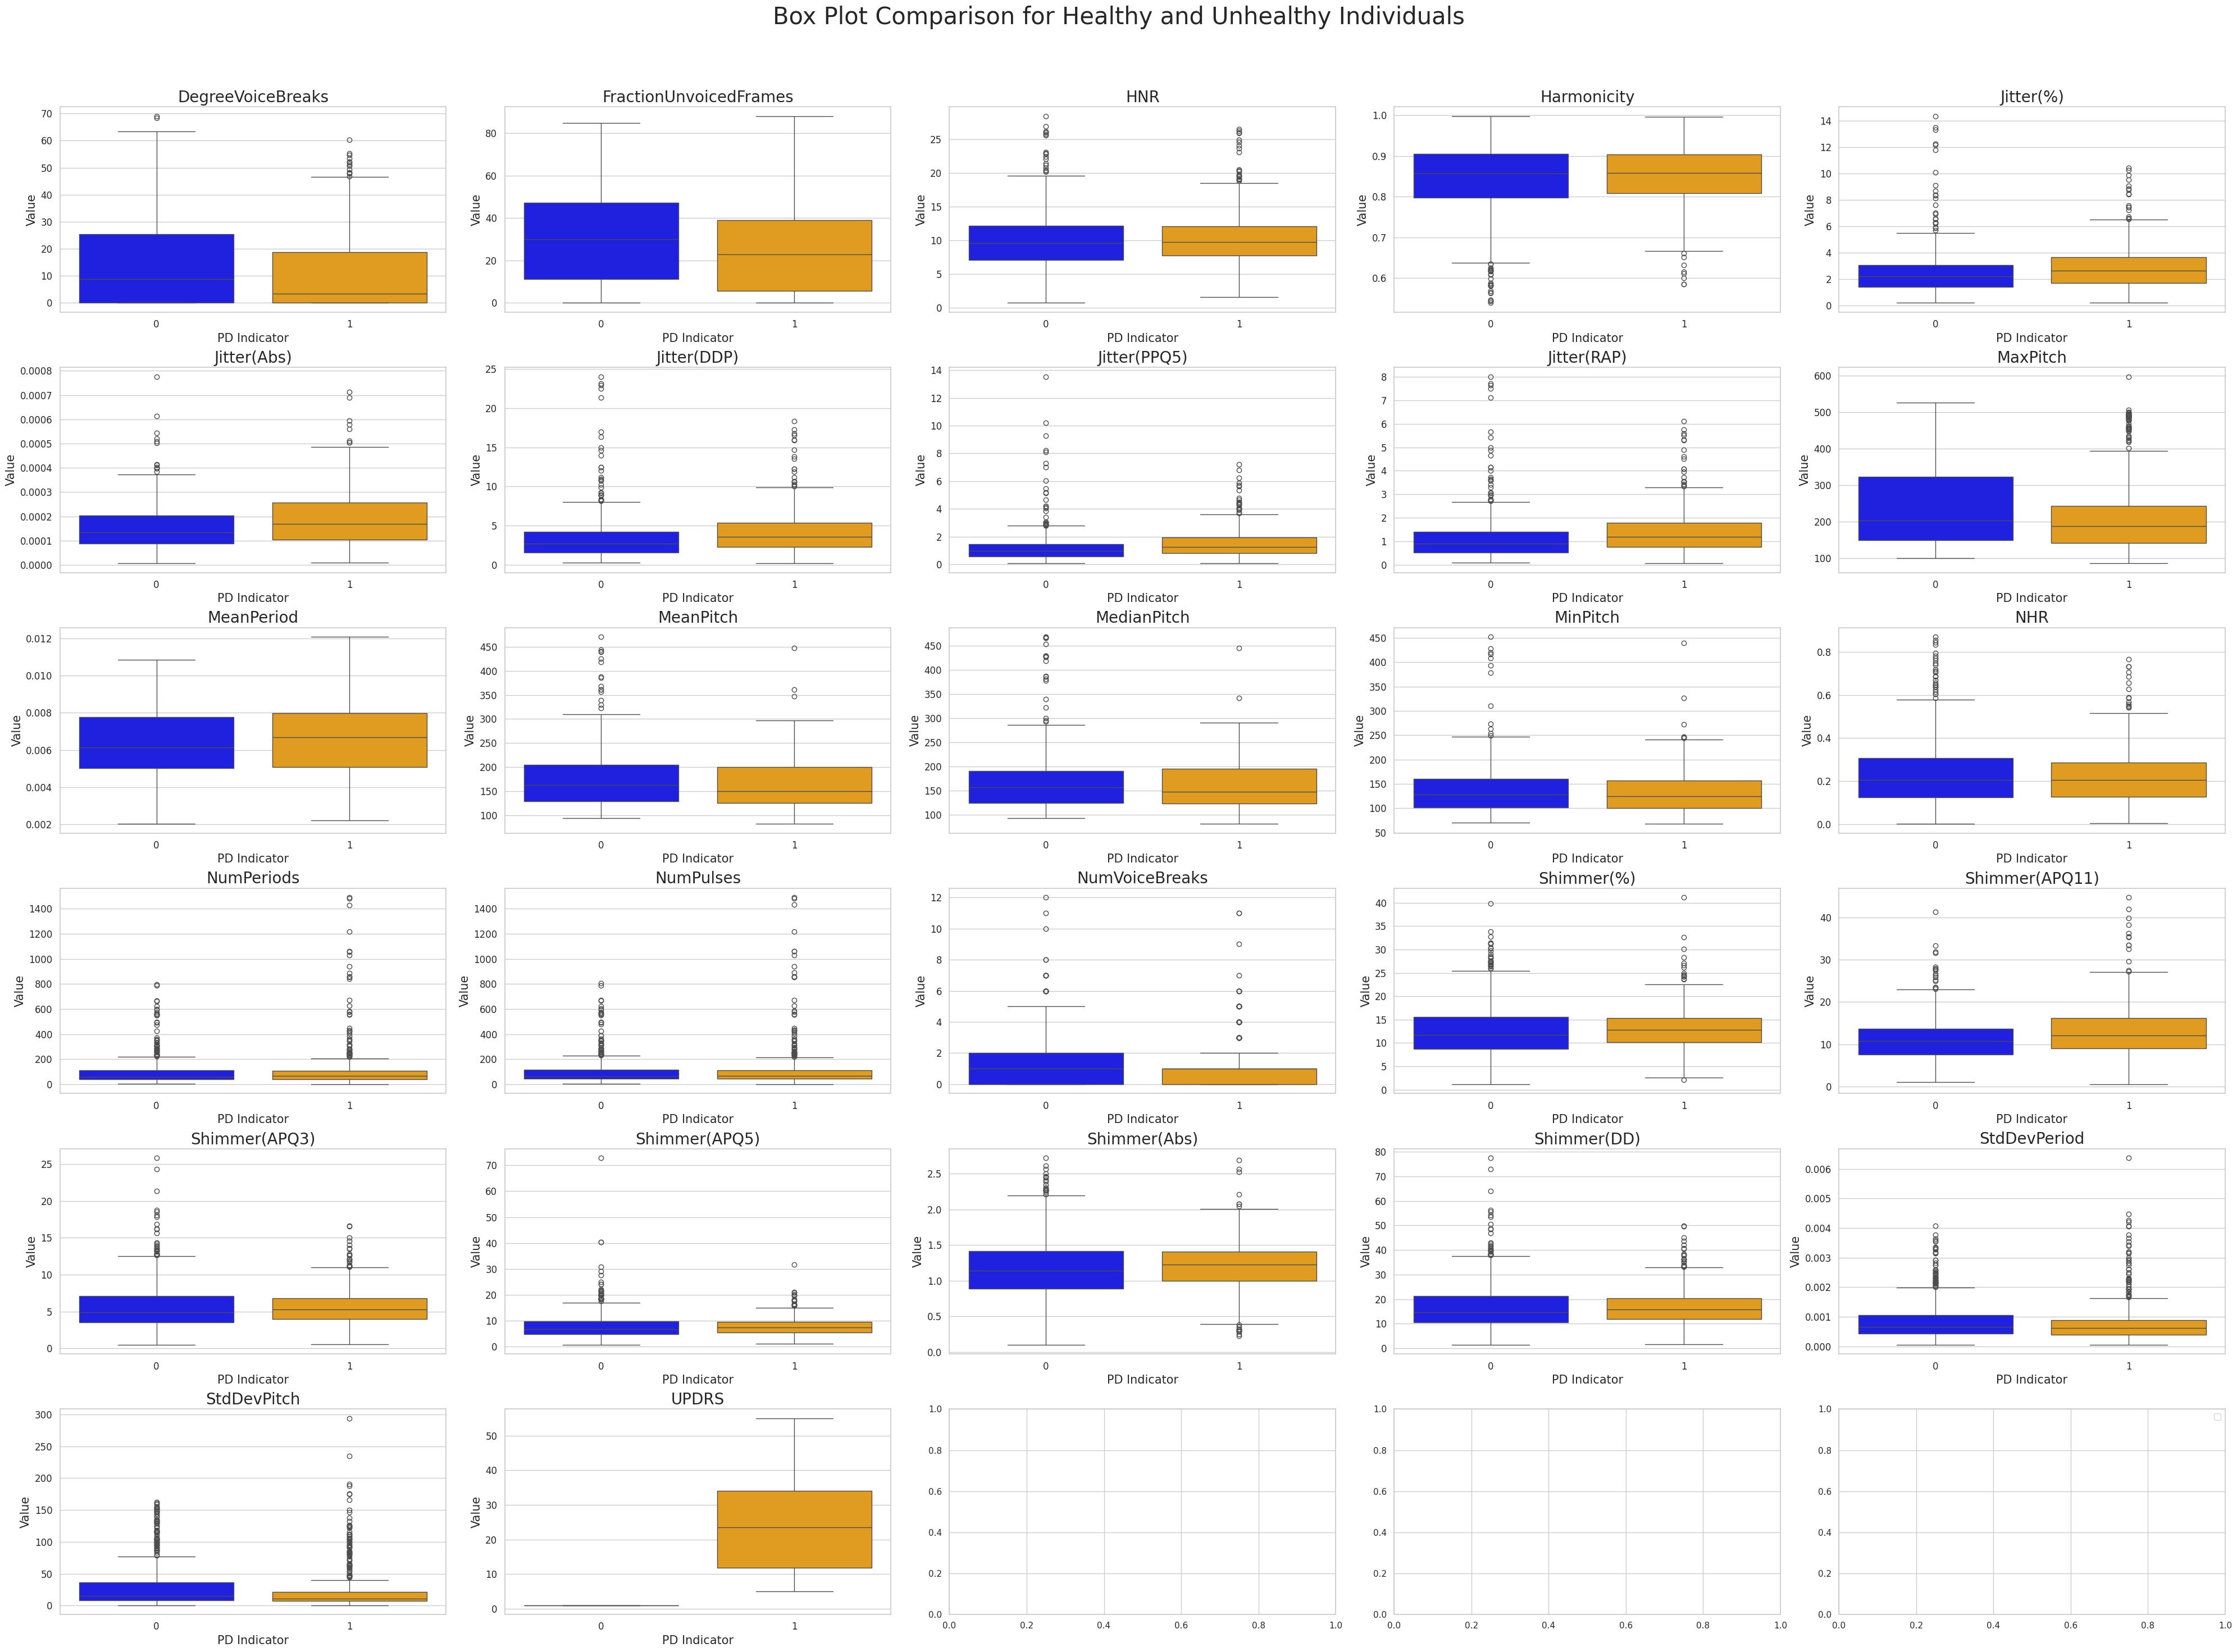

In [ ]:
# Select numeric columns for box plots
numeric_columns = df1.select_dtypes(include=['float64', 'int64']).columns

# Exclude specific columns
columns_to_exclude = ["Subject_ID", "PD Indicator"]
numeric_columns = numeric_columns.difference(columns_to_exclude)

# Set up the Seaborn style
sns.set(style="whitegrid")

# Create a 6 by 5 grid of axes for the box plots
fig, axes = plt.subplots(6, 5, figsize=(40, 30))
axes = axes.flatten()

# Create a box plot for each numeric column in df1 and df2
for i, column in enumerate(numeric_columns):
    sns.boxplot(data=df1, x="PD Indicator", y=column, ax=axes[i], color="blue")
    sns.boxplot(data=df2, x="PD Indicator", y=column, ax=axes[i], color="orange")

    # Add hatches for the boxes
    for patch in axes[i].artists:
        patch.set_hatch('//')

    axes[i].set_title(column, fontsize=20)
    axes[i].set_xlabel("PD Indicator", fontsize=15)
    axes[i].set_ylabel("Value", fontsize=15)
    axes[i].tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.suptitle("Box Plot Comparison for Healthy and Unhealthy Individuals", fontsize=30)
plt.subplots_adjust(top=0.92)
plt.legend(labels=["Healthy", "Unhealthy"])
plt.show()

In [ ]:
# List of features/columns in your dataset
features = df1.columns.difference(["Subject_ID", "PD Indicator"])

# Initialize empty lists to store results
selected_features = []
mean_differences = []
confidence_intervals = []
absolute_mean_differences = []  # New list to store absolute mean differences

# Loop through each feature
for feature in features:
    # Calculate mean and standard error for each group
    mean_healthy = df1[feature].mean()
    mean_unhealthy = df2[feature].mean()
    std_error_healthy = df1[feature].std() / np.sqrt(len(df1))
    std_error_unhealthy = df2[feature].std() / np.sqrt(len(df2))

    # Calculate the t-statistic
    t_statistic = (mean_unhealthy - mean_healthy) / np.sqrt(std_error_healthy**2 + std_error_unhealthy**2)

    # Calculate degrees of freedom for the t-distribution
    dof = len(df1) + len(df2) - 2

    # Calculate the critical value for the t-distribution
    t_critical = t.ppf(0.975, dof)  # 95% confidence level

    # Calculate the margin of error
    margin_of_error = t_critical * np.sqrt((std_error_healthy**2 + std_error_unhealthy**2) / 2)

    # Calculate the confidence interval
    ci_lower = (mean_unhealthy - mean_healthy) - margin_of_error
    ci_upper = (mean_unhealthy - mean_healthy) + margin_of_error

    # Check if confidence intervals do not overlap
    if ci_lower > 0 or ci_upper < 0:
        selected_features.append(feature)
        mean_difference = mean_unhealthy - mean_healthy
        mean_differences.append(mean_difference)
        confidence_intervals.append((ci_lower, ci_upper))
        absolute_mean_differences.append(abs(mean_difference))  # Add the absolute mean difference

# Create a DataFrame to store the results
feature_selection_results = pd.DataFrame({
    'Feature': selected_features,
    'Mean Difference': mean_differences,
    'Confidence Interval': confidence_intervals,
    'Absolute Mean Difference': absolute_mean_differences  # Add the absolute mean difference column
})

# Sort features based on larger absolute mean differences and narrower CIs
sorted_results = feature_selection_results.sort_values(by=['Absolute Mean Difference', 'Confidence Interval'], ascending=[False, True])

# Drop the "Absolute Mean Difference" column
sorted_results = sorted_results.drop(columns='Absolute Mean Difference')

# Print the sorted results with formatting
pd.options.display.float_format = '{:.3f}'.format
print(sorted_results.to_string(index=False))


# Define the file path where you want to save the top 10 results
output_file_path = 'sorted_results.csv'

# Save the top 10 rows of the sorted results to a CSV file
top_10_sorted_results = sorted_results.head(10)
top_10_sorted_results.to_csv(output_file_path, index=False)

print("Top 10 results saved to", output_file_path)

               Feature  Mean Difference                                Confidence Interval
              MaxPitch          -33.869          (-44.23053281904596, -23.507430719415524)
                 UPDRS           24.000             (23.10322033966514, 24.89677966033486)
            NumPeriods           14.069            (1.2199114848230206, 26.91855005363852)
             MeanPitch          -11.555          (-16.347296998576173, -6.761713001423839)
           MedianPitch           -9.432          (-14.237854562260676, -4.626103130047061)
           StdDevPitch           -8.876           (-12.009938180962953, -5.74195997288321)
              MinPitch           -5.560          (-9.604171427819502, -1.5157022644881915)
FractionUnvoicedFrames           -5.117         (-6.9096498697142215, -3.3250424379780776)
     DegreeVoiceBreaks           -3.824          (-5.118428282744146, -2.5286486403327775)
        Shimmer(APQ11)            1.760            (1.2474458855299606, 2.272198372162342)

In [ ]:
# List of features/columns in your dataset
features = df1.columns.difference(["Subject_ID", "PD Indicator"])
# Set the significance level
alpha = 0.05
# Initialize empty lists to store results
reject_results = []
fail_to_reject_results = []
# Loop through each feature
for feature in features:
    # Calculate sample means and standard deviations
    mean_healthy = df1[feature].mean()
    mean_unhealthy = df2[feature].mean()
    std_healthy = df1[feature].std()
    std_unhealthy = df2[feature].std()
    n_healthy = len(df1)
    n_unhealthy = len(df2)
    # Calculate the pooled standard error
    pooled_std = np.sqrt((std_healthy**2 / n_healthy) + (std_unhealthy**2 / n_unhealthy))
    # Calculate the z-score
    z_score = (mean_unhealthy - mean_healthy) / pooled_std
    # Calculate the critical z-value for two-tailed test
    critical_z = norm.ppf(1 - alpha / 2)
    # Perform the hypothesis test
    result_dict = {
        "Feature": feature,
        "Z-Score": z_score,
        "Critical Z-Value": critical_z,
        "Result": "Reject H0" if np.abs(z_score) > critical_z else "Fail to reject H0"
    }
    # Store the results in the appropriate list
    if result_dict["Result"] == "Reject H0":
        reject_results.append(result_dict)
    else:
        fail_to_reject_results.append(result_dict)
# Create DataFrames for the results
reject_results_df = pd.DataFrame(reject_results)
fail_to_reject_results_df = pd.DataFrame(fail_to_reject_results)

# Display the results for "Reject H0"
print("Reject H0:")
print(reject_results_df)

# Display the results for "Fail to reject H0"
print("\nFail to reject H0:")
print(fail_to_reject_results_df)


# Create DataFrames for the results
reject_results_df = pd.DataFrame(reject_results)
fail_to_reject_results_df = pd.DataFrame(fail_to_reject_results)

# Define the file paths for saving the results
reject_output_file_path = 'reject_results.csv'
fail_to_reject_output_file_path = 'fail_to_reject_results.csv'

# Save the results to CSV files
reject_results_df.to_csv(reject_output_file_path, index=False)
fail_to_reject_results_df.to_csv(fail_to_reject_output_file_path, index=False)

print("Rejected results saved to", reject_output_file_path)

Reject H0:
                   Feature  Z-Score  Critical Z-Value     Result
0        DegreeVoiceBreaks   -4.097             1.960  Reject H0
1   FractionUnvoicedFrames   -3.962             1.960  Reject H0
2              Harmonicity    2.621             1.960  Reject H0
3                Jitter(%)    3.158             1.960  Reject H0
4              Jitter(Abs)    5.457             1.960  Reject H0
5              Jitter(DDP)    3.603             1.960  Reject H0
6             Jitter(PPQ5)    3.596             1.960  Reject H0
7              Jitter(RAP)    3.603             1.960  Reject H0
8                 MaxPitch   -4.535             1.960  Reject H0
9               MeanPeriod    2.643             1.960  Reject H0
10               MeanPitch   -3.345             1.960  Reject H0
11             MedianPitch   -2.723             1.960  Reject H0
12                     NHR   -2.458             1.960  Reject H0
13          NumVoiceBreaks   -2.580             1.960  Reject H0
14          Sh

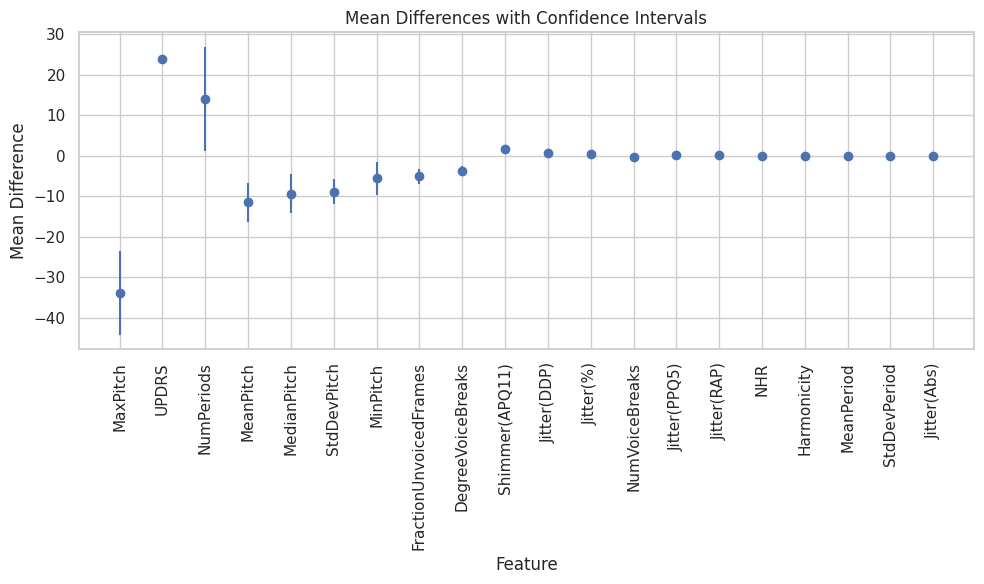

Common features:
['DegreeVoiceBreaks' 'FractionUnvoicedFrames' 'MaxPitch' 'MeanPitch'
 'MedianPitch' 'Shimmer(APQ11)' 'StdDevPitch' 'UPDRS']


array(['DegreeVoiceBreaks', 'FractionUnvoicedFrames', 'MaxPitch',
       'MeanPitch', 'MedianPitch', 'Shimmer(APQ11)', 'StdDevPitch',
       'UPDRS'], dtype=object)

In [ ]:
# Extract confidence interval lower and upper bounds
sorted_results['CI_Lower'] = sorted_results['Confidence Interval'].apply(lambda x: x[0])
sorted_results['CI_Upper'] = sorted_results['Confidence Interval'].apply(lambda x: x[1])

# Plot mean differences with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(sorted_results['Feature'], sorted_results['Mean Difference'], yerr=[sorted_results['Mean Difference'] - sorted_results['CI_Lower'], sorted_results['CI_Upper'] - sorted_results['Mean Difference']], fmt='o')
plt.xlabel('Feature')
plt.ylabel('Mean Difference')
plt.title('Mean Differences with Confidence Intervals')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
####################################################################

""" Saving the data for Null Hypothesis and sorted mean differences """
df3 = pd.read_csv('./reject_results.csv')
df4 = pd.read_csv('./sorted_results.csv')
common_features = np.intersect1d(df3['Feature'], df4['Feature'])
print("Common features:")
print(common_features)

selected_df1 = df1[common_features]
selected_df2 = df2[common_features]
common_features

In [ ]:
selected_features=common_features
target_classification = 'PD Indicator'

In [ ]:
X = df[selected_features].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
y_class = df[target_classification].values  # Binary classification target

In [ ]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42,stratify=y_class)

In [ ]:
input_shape = (X_train_class.shape[1], 1)  # The second dimension is the number of features after PCA
# Input Layer
input_layer = Input(shape=input_shape)

In [ ]:
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

attention = MultiHeadAttention(num_heads=4, key_dim=64)(query=x, value=x, key=x)
x = Bidirectional(GRU(128, return_sequences=True))(attention)
x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 8, 1)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 8, 32)          │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 8, 32)          │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 4, 32)          │              0 │ batch_normalization[0… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 4, 64)          │          6,208 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 4, 64)          │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 2, 64)          │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 2, 128)         │         24,704 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 2, 128)         │            512 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 1, 128)         │              0 │ batch_normalization_2… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 128)         │        131,968 │ max_pooling1d_2[0][0], │
│ (MultiHeadAttention)      │                        │                │ max_pooling1d_2[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 256)         │        198,144 │ multi_head_attention[… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 428,097 (1.63 MB)

 Trainable params: 427,649 (1.63 MB)

 Non-trainable params: 448 (1.75 KB)

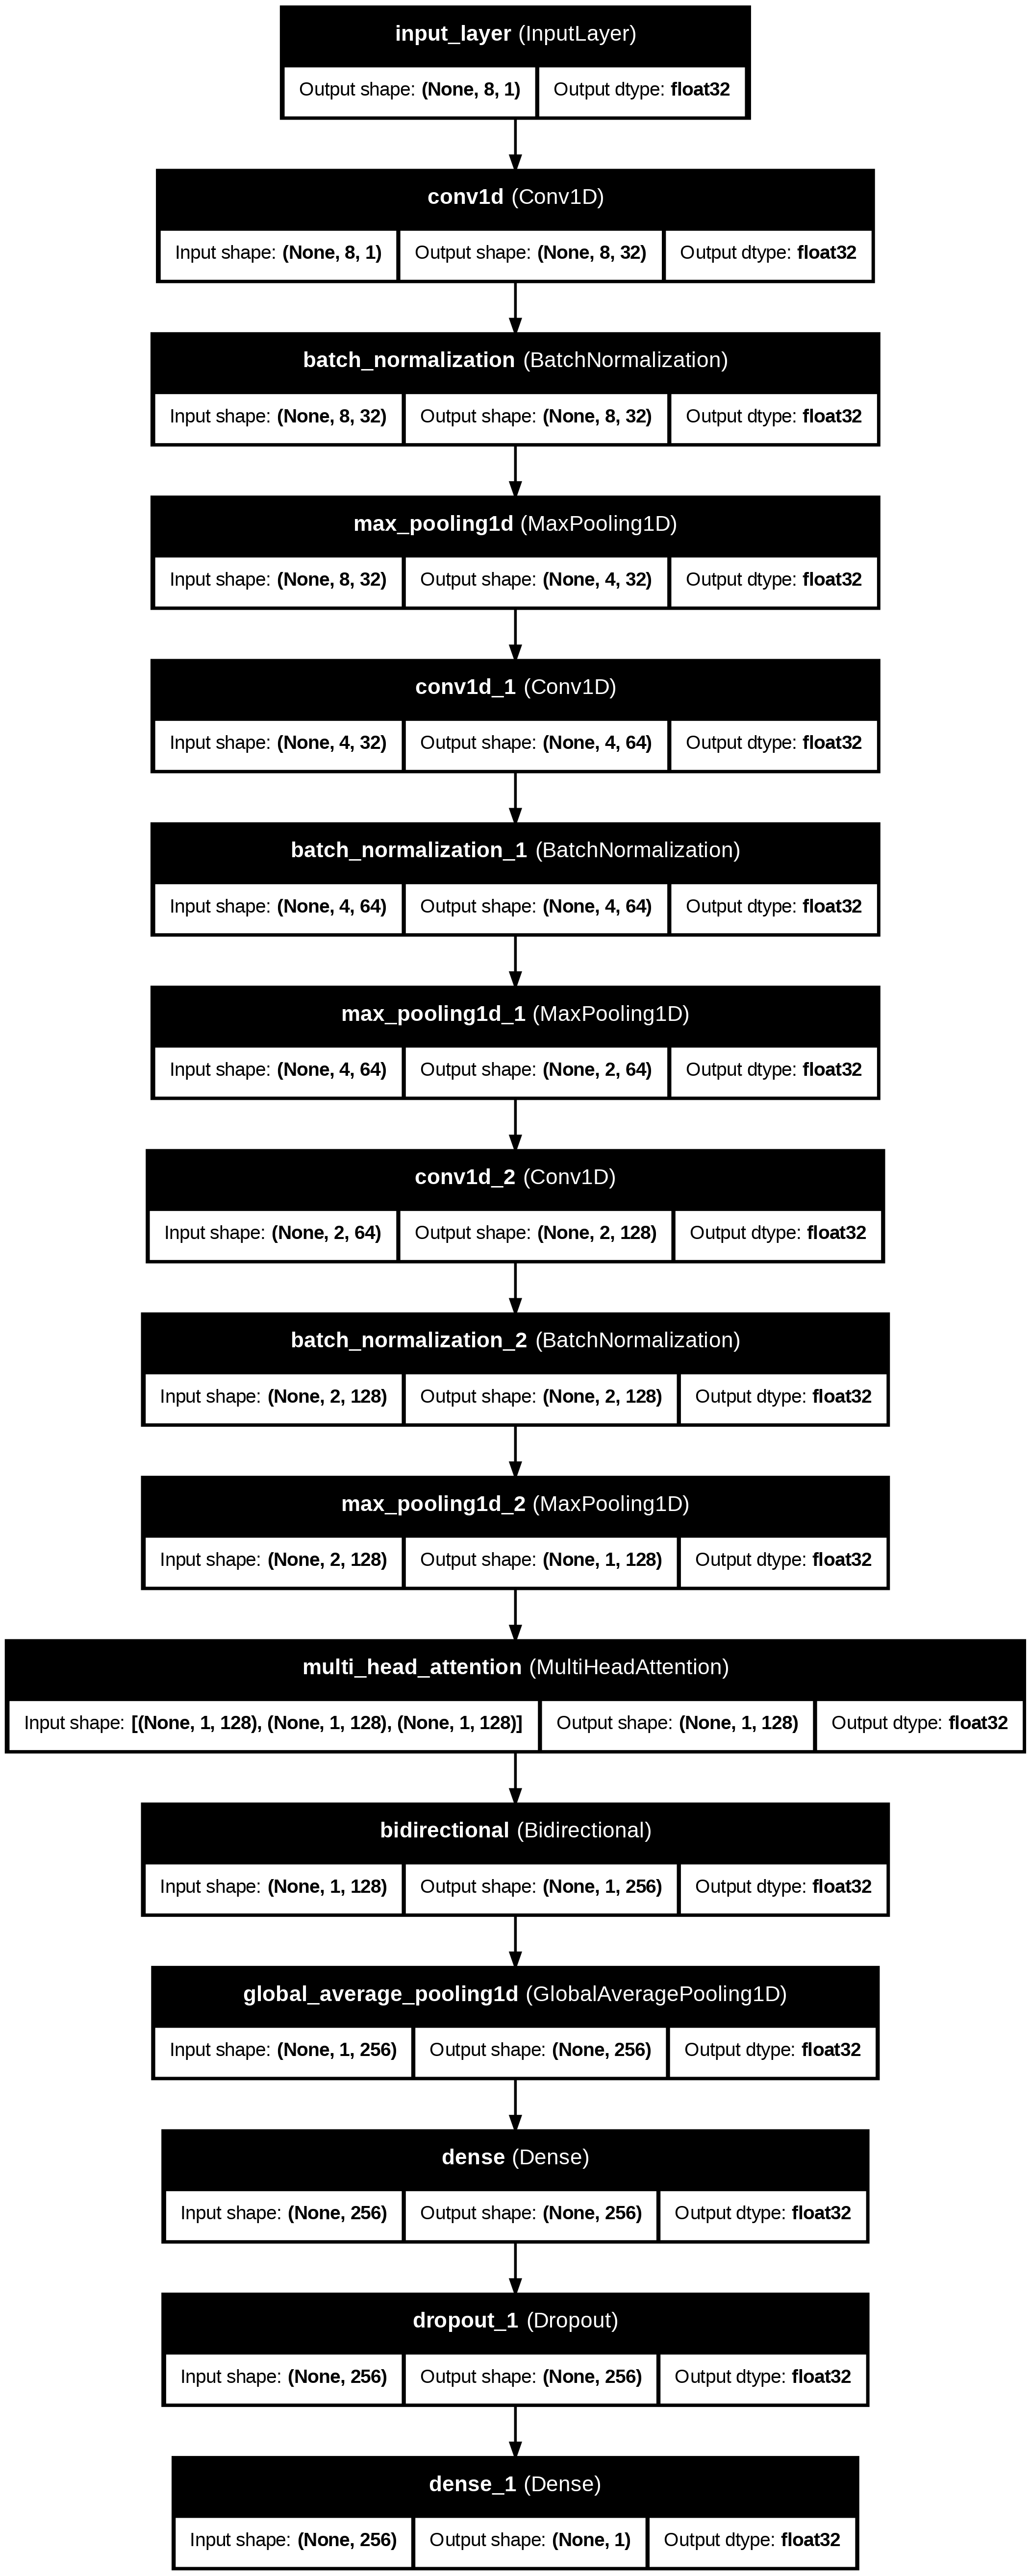

In [ ]:
plot_model(model,to_file="PD_Detection_CNN_Model.png",show_layer_names=True,show_dtype=True,show_shapes=True)

In [ ]:
# Training the model using X_train_reshaped and y_train
history = model.fit(X_train_class, y_train_class, epochs=50, batch_size=32, validation_data=(X_test_class, y_test_class))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7309 - loss: 2.7546

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7339 - loss: 2.7380 - val_accuracy: 0.6250 - val_loss: 1.9062
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9257 - loss: 1.2719 - val_accuracy: 0.5000 - val_loss: 1.2817
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9426 - loss: 0.6480 - val_accuracy: 0.5000 - val_loss: 1.1059
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9244 - loss: 0.4673 - val_accuracy: 0.5000 - val_loss: 1.1738
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9709 - loss: 0.1937 - val_accuracy: 0.5000 - val_loss: 1.0129
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9739 - loss: 0.1319 - val_accuracy: 0.5385 - val_loss: 0.7549
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9669 - loss: 0.1268 - val_accuracy: 0.5096 - val_loss: 0.7877
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9821 - loss: 0.0772 - val_accuracy: 0.7308 - val_loss: 0.

In [ ]:
model.save('PD_Detection_Model_1.h5')

In [ ]:
# Generate predictions on the test set
y_pred = (model.predict(X_test_class) > 0.7).astype("int32")

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_class, y_pred))

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_test_class, y_pred)
print(f"Accuracy Score: {accuracy}")

In [ ]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Detecting PD for a patient

## Dataset used:

  ### [Telemonitoring (TE) Dataset ](http://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring)
  The data was gathered from 42 people with early-stage Parkinson's disease. There are 16 voice measures, and two regression measurements: motor UPDRS and total UPDRS. Each row of the dataset contain corresponds to one voice recording. There are around 200 recordings per patient, the subject number of the patient is identified in the first column.

  Features
  - subject# - Integer that uniquely identifies each subject
  - age - Subject age
  - sex - Subject gender '0' - male, '1' - female
  - test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment.
  - motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated
  - total_UPDRS - Clinician's total UPDRS score, linearly interpolated
  - Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of variation in fundamental frequency
  - Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - Several measures of variation in amplitude
  - NHR,HNR - Two measures of ratio of noise to tonal components in the voice
  - RPDE - A nonlinear dynamical complexity measure
  - DFA - Signal fractal scaling exponent
  - PPE - A nonlinear measure of fundamental frequency variation

In [ ]:
# Load the severity dataset
df_severity = pd.read_csv('/content/drive/MyDrive/telemonitoring_parkinsons_updrs.data.csv')

In [ ]:
df_severity.head()

Predicting the UPDRS score with these features (according to the Telemonitoring Dataset)

- Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of variation in fundamental frequency
- Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- RPDE - A nonlinear dynamical complexity measure
- DFA - Signal fractal scaling exponent
- PPE - A nonlinear measure of fundamental frequency variation

The dataset has motor_UPDRS and total_UPDRS which have a high correlation with each other. So, we used the other features given above to predict motor_UPDRS score and then use all the features along with motor_UPDRS score predicted to predict the total_UPDRS score. This UPDRS score will be used to detect PD using the CNN model

Function to display the predictions

In [ ]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Prediction Line')
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid()
    plt.show()

## Model to predict motor_UPDRS

In [ ]:
# Dataset Preprocessing for Severity Analysis
X_severity_motor = df_severity.drop(columns=['total_UPDRS','subject#','motor_UPDRS','test_time'])  # Drop 'total_UPDRS' column
y_severity_motor = df_severity['motor_UPDRS']  # Target for UPDRS score prediction

In [ ]:
# Feature Scaling for Severity Dataset
scaler_severity = StandardScaler()
X_scaled_severity_motor = scaler_severity.fit_transform(X_severity_motor)

In [ ]:
# Train-test split for severity analysis
X_train_severity_motor, X_test_severity_motor, y_train_severity_motor, y_test_severity_motor = train_test_split(
    X_scaled_severity_motor, y_severity_motor, test_size=0.2, random_state=42
)

# Reshape the data for Conv1D model
X_train_severity_reshaped_motor = X_train_severity_motor.reshape(X_train_severity_motor.shape[0], X_train_severity_motor.shape[1], 1)
X_test_severity_reshaped_motor = X_test_severity_motor.reshape(X_test_severity_motor.shape[0], X_test_severity_motor.shape[1], 1)

In [ ]:
# Define the improved severity model
input_layer_severity = Input(shape=(X_train_severity_motor.shape[1], 1))

# Enhanced CNN Layers
x_severity = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer_severity)
x_severity = BatchNormalization()(x_severity)
x_severity = MaxPooling1D(pool_size=2)(x_severity)
x_severity = Dropout(0.3)(x_severity)

x_severity = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x_severity)
x_severity = BatchNormalization()(x_severity)
x_severity = MaxPooling1D(pool_size=2)(x_severity)
x_severity = Dropout(0.3)(x_severity)

# GRU Layers
x_severity = GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x_severity)
x_severity = GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(x_severity)

# Fully Connected Layers
x_severity = Dense(512, activation='relu')(x_severity)
x_severity = Dropout(0.4)(x_severity)
x_severity = Dense(128, activation='relu')(x_severity)
x_severity = Dropout(0.4)(x_severity)

# Output Layer for regression (UPDRS prediction)
output_layer_severity = Dense(1, activation='linear')(x_severity)

In [ ]:
# Compile the model with a learning rate scheduler
model_severity = Model(inputs=input_layer_severity, outputs=output_layer_severity)
optimizer = Adam(learning_rate=0.001)
model_severity.compile(optimizer=optimizer, loss='mean_squared_error')

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
model.summary()

In [ ]:
plot_model(model_severity,to_file="motor_UPDRS_CNN_Model.png",show_layer_names=True,show_dtype=True,show_shapes=True)

In [ ]:
# Training the improved severity model
history_severity = model_severity.fit(
    X_train_severity_reshaped_motor, y_train_severity_motor,
    epochs=50, batch_size=32,
    validation_data=(X_test_severity_reshaped_motor, y_test_severity_motor),
    callbacks=[lr_scheduler]
)

In [ ]:
# Evaluate the improved severity model
test_loss_severity = model_severity.evaluate(X_test_severity_reshaped_motor, y_test_severity_motor)
print(f"motor_UPDRS prediction - Test Loss (MSE): {test_loss_severity}")

# Generate predictions for Severity Analysis
y_pred_severity = model_severity.predict(X_test_severity_reshaped_motor)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_severity_motor, y_pred_severity)
r2 = r2_score(y_test_severity_motor, y_pred_severity)

print(f"Mean Absolute Error for motor_UPDRS prediction: {mae}")
print(f"R² Score for motor_UPDRS prediction: {r2}")


In [ ]:
plot_predictions(y_test_severity_motor, y_pred_severity, title="Predicted vs Actual Motor_UPDRS (Neural Network)")

Trying with XGBoost

In [ ]:
# Initialize and train XGBoost Regressor
xgb_model_motor = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model_motor.fit(X_train_severity_motor, y_train_severity_motor)

# Generate predictions
y_pred_xgb = xgb_model_motor.predict(X_test_severity_motor)

# Evaluation Metrics
mae_xgb = mean_absolute_error(y_test_severity_motor, y_pred_xgb)
r2_xgb = r2_score(y_test_severity_motor, y_pred_xgb)

print(f"XGBoost - Mean Absolute Error: {mae_xgb}")
print(f"XGBoost - R² Score: {r2_xgb}")


In [ ]:
plot_predictions(y_test_severity_motor, y_pred_xgb, title="Predicted vs Actual Motor_UPDRS (XGBoost)")

Trying with LightGBM (Light Gradient Boosting Machine)

In [ ]:
# Initialize and train LightGBM Regressor
lgbm_model_motor = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model_motor.fit(X_train_severity_motor, y_train_severity_motor)

# Generate predictions
y_pred_lgbm = lgbm_model_motor.predict(X_test_severity_motor)

# Evaluation Metrics
mae_lgbm = mean_absolute_error(y_test_severity_motor, y_pred_lgbm)
r2_lgbm = r2_score(y_test_severity_motor, y_pred_lgbm)

print(f"LightGBM - Mean Absolute Error: {mae_lgbm}")
print(f"LightGBM - R² Score: {r2_lgbm}")


In [ ]:
plot_predictions(y_test_severity_motor, y_pred_lgbm, title="Predicted vs Actual Motor_UPDRS (LGBM)")

Trying with RF regressor

In [ ]:
# Initialize and train Random Forest Regressor
rf_model_motor = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    random_state=42
)
rf_model_motor.fit(X_train_severity_motor, y_train_severity_motor)

# Generate predictions
y_pred_rf = rf_model_motor.predict(X_test_severity_motor)

# Evaluation Metrics
mae_rf = mean_absolute_error(y_test_severity_motor, y_pred_rf)
r2_rf = r2_score(y_test_severity_motor, y_pred_rf)

print(f"Random Forest - Mean Absolute Error: {mae_rf}")
print(f"Random Forest - R² Score: {r2_rf}")


In [ ]:
plot_predictions(y_test_severity_motor, y_pred_rf, title="Predicted vs Actual Motor_UPDRS (Random Forest Regressor)")

Selecting the best model for motor_UPDRS prediction

In [ ]:
best_model_rf=max(r2_rf,r2_lgbm,r2_xgb,r2)
if best_model_rf==r2_rf:
  print("Random Forest")
  model_motor=rf_model_motor
elif best_model_rf==r2_lgbm:
  print("LightGBM")
  model_motor=lgbm_model_motor
elif best_model_rf==r2_xgb:
  print("XGBoost")
  model_motor=xgb_model_motor
else:
  print("Neural network")
  model_motor=model_severity

In [ ]:
import pickle
with open('motor_UPDRS_model.pkl', 'wb') as file:
    pickle.dump(model_motor, file)

In [ ]:
import pickle
with open('PD_Detection_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Model to predict total_UPDRS

We are using the same telemonitoring dataset to predict the value of total_UPDRS using the predicted value of motor_UPDRS along with the other features

In [ ]:
# Dataset Preprocessing for Severity Analysis
X_severity = df_severity.drop(columns=['total_UPDRS','subject#','test_time'])  # Drop unwanted columns
y_severity = df_severity['total_UPDRS']  # Target for UPDRS score prediction

In [ ]:
# Feature Scaling for Severity Dataset
scaler_severity = StandardScaler()
X_scaled_severity = scaler_severity.fit_transform(X_severity)

In [ ]:
# Train-test split for severity analysis
X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
    X_scaled_severity, y_severity, test_size=0.2, random_state=42
)

# Reshape the data for Conv1D model
X_train_severity_reshaped = X_train_severity.reshape(X_train_severity.shape[0], X_train_severity.shape[1], 1)
X_test_severity_reshaped = X_test_severity.reshape(X_test_severity.shape[0], X_test_severity.shape[1], 1)

In [ ]:
# Model for Severity Analysis
input_layer_severity = Input(shape=(X_train_severity.shape[1], 1))

# CNN Layers for Severity
x_severity = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer_severity)
x_severity = MaxPooling1D(pool_size=2)(x_severity)
x_severity = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x_severity)
x_severity = MaxPooling1D(pool_size=2)(x_severity)

# GRU Layer for Severity
x_severity = GRU(128, return_sequences=True)(x_severity)

# Global Average Pooling
x_severity = GlobalAveragePooling1D()(x_severity)

# Fully Connected Layer
x_severity = Dense(256, activation='relu')(x_severity)
x_severity = Dropout(0.5)(x_severity)

# Output Layer for regression (UPDRS prediction)
output_layer_severity = Dense(1, activation='linear')(x_severity)

In [ ]:
# Define the severity model
model_severity_total = Model(inputs=input_layer_severity, outputs=output_layer_severity)
model_severity_total.compile(optimizer='adam', loss='mean_squared_error')
# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
model_severity_total.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 19, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 19, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 9, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 4, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,113 (445.75 KB)

 Trainable params: 114,113 (445.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the severity analysis model
history_severity = model_severity_total.fit(X_train_severity_reshaped, y_train_severity, epochs=30, batch_size=64, validation_data=(X_test_severity_reshaped, y_test_severity),callbacks=[lr_scheduler])

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 584.0680 - val_loss: 102.5608 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 110.1389 - val_loss: 62.4341 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 58.5288 - val_loss: 15.6800 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 23.8198 - val_loss: 11.2396 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.4932 - val_loss: 9.9643 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 19.7377 - val_loss: 8.9301 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 18.3697 - val_loss: 8.3096 - learning_rate: 0.0010
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.0795 - val_loss: 9.4236 - learning_rate: 0.0010
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.2962 - val_loss: 8.1403 - learning_rate: 0.0010
Epo

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7164
TotalUPDRS prediction - Test Loss (MSE): 4.929441452026367
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Mean Absolute Error for total_UPDRS prediction: 1.7677161494757472
R² Score for total_UPDRS prediction: 0.9555156905231972


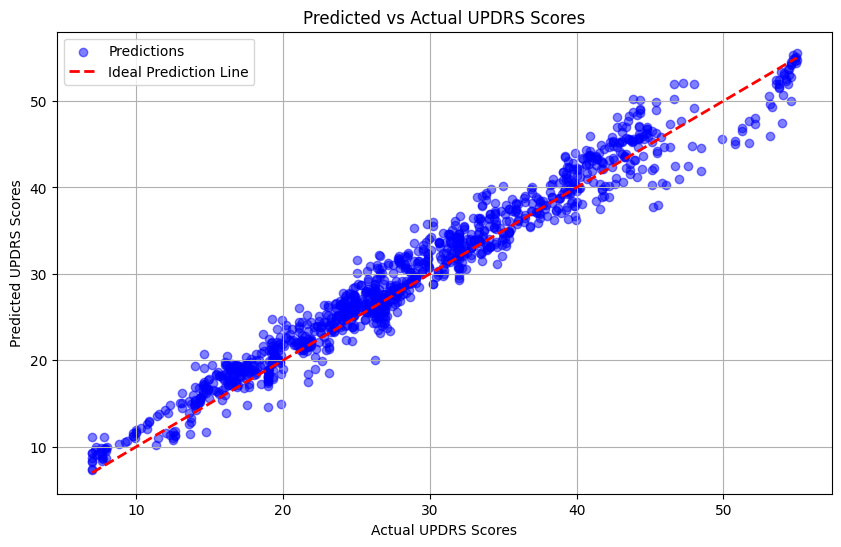

In [ ]:
# Evaluate the severity model
test_loss_severity = model_severity_total.evaluate(X_test_severity_reshaped, y_test_severity)
print(f"TotalUPDRS prediction - Test Loss (MSE): {test_loss_severity}")

# Generate predictions for Severity Analysis
y_pred_severity = model_severity_total.predict(X_test_severity_reshaped)

# Calculate evaluation metrics
mae_total = mean_absolute_error(y_test_severity, y_pred_severity)
r2_total = r2_score(y_test_severity, y_pred_severity)
model_severity_total.save('Severity_Analysis_Model.h5')
print(f"Mean Absolute Error for total_UPDRS prediction: {mae_total}")
print(f"R² Score for total_UPDRS prediction: {r2_total}")

# Visualization: Predicted vs Actual UPDRS Scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test_severity, y_pred_severity, color='blue', label='Predictions', alpha=0.5)
plt.plot([y_test_severity.min(), y_test_severity.max()], [y_test_severity.min(), y_test_severity.max()], 'r--', lw=2, label='Ideal Prediction Line')
plt.title('Predicted vs Actual UPDRS Scores')
plt.xlabel('Actual UPDRS Scores')
plt.ylabel('Predicted UPDRS Scores')
plt.legend()
plt.grid()
plt.show()

# Feature Extraction from real world voice samples

We have used Praat (Praat is a free, open-source computer software package widely used for speech analysis and synthesis in phonetics and other fields of linguistics.) for the extraction of speech features from the voice sample

Helper functions

In [ ]:
def calculate_dfa(y):
    return nolds.dfa(y)

def calculate_ppe(pitch_values):
    pitch_values = pitch_values[pitch_values > 0]  # Exclude unvoiced regions
    if len(pitch_values) == 0:
        return 0.0
    normalized_pitch = (pitch_values - np.mean(pitch_values)) / np.std(pitch_values)
    hist, _ = np.histogram(normalized_pitch, bins=100, density=True)
    ppe = entropy(hist + 1e-10)
    return ppe
def calculate_rpde(y):
    # RPDE via entropy
    normalized_signal = (y - np.min(y)) / (np.max(y) - np.min(y))
    hist, _ = np.histogram(normalized_signal, bins=100, density=True)
    rpde = entropy(hist + 1e-10)
    return rpde

Main function to extract voice features

In [ ]:
def extract_voice_features(age,sex,file_path):
    # Load sound file
    sound = parselmouth.Sound(file_path)

    # Fundamental frequency (F0) settings
    f0min = 75  # Minimum pitch in Hertz
    f0max = 600  # Maximum pitch in Hertz
    unit = "Hertz"

    # Extract pitch-related features
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)
    pitch_values = np.array([pitch.get_value_at_time(t) for t in np.arange(0, sound.duration, 0.01)])
    meanF0 = call(pitch, "Get mean", 0, 0, unit)  # Mean F0
    stdevF0 = call(pitch, "Get standard deviation", 0, 0, unit)  # Standard deviation of F0

    # Harmonicity (HNR)
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)

    # Noise-to-Harmonics Ratio (NHR) (inversely related to HNR)
    nhr = 1 / hnr if hnr != 0 else float('inf')

    # Point Process for jitter and shimmer measures
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)

    # Jitter measures
    jitter_local = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_abs = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_rap = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_ppq5 = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    jitter_ddp = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)

    # Shimmer measures
    shimmer_local = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_dB = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq3 = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq5 = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq11 = call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_dda = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    # Calculate RPDE
    rpde = calculate_rpde(sound.values[0])

    # Calculate DFA
    dfa = calculate_dfa(sound.values[0])

    # Calculate PPE
    ppe = calculate_ppe(pitch_values)

    return {
      "age": age,
    "sex": sex,
    "Jitter (%)": jitter_local,  # Jitter percentage
    "meanF0": meanF0,
    "stdevF0": stdevF0,
    "hnr": hnr,
    "nhr": nhr,
    "Jitter (Abs)": jitter_abs,
    "Jitter (RAP)": jitter_rap,
    "Jitter (PPQ5)": jitter_ppq5,
    "Jitter (DDP)": jitter_ddp,
    "Shimmer": shimmer_local,
    "Shimmer (dB)": shimmer_dB,
    "Shimmer (APQ3)": shimmer_apq3,
    "Shimmer (APQ5)": shimmer_apq5,
    "Shimmer (APQ11)": shimmer_apq11,
    "Shimmer (DDA)": shimmer_dda,
    "RPDE": rpde,
    "DFA": dfa,
    "PPE": ppe,
}


In [ ]:
file_path = "/content/drive/MyDrive/Parkinsons_final_yr/data/mozillaClips/tstClip.mp3"
age=int(input('Enter the age of the patient: '))
sex_in=input('Enter the sex of patient (M/F) ')
sex=0
if sex_in=='M':
  sex=0
elif sex_in=='F':
  sex=1
features = extract_voice_features(age,sex,file_path)
print(features)

Predicting motor_UPDRS value


In [ ]:
# Required features for motor_UPDRS prediction
required_features = [
    "age","sex","Jitter (%)", "Jitter (Abs)", "Jitter (RAP)", "Jitter (PPQ5)", "Jitter (DDP)",
    "Shimmer", "Shimmer (dB)", "Shimmer (APQ3)", "Shimmer (APQ5)", "Shimmer (APQ11)",
    "Shimmer (DDA)", "nhr", "hnr", "RPDE", "DFA", "PPE"
]

# Filter only the required features
filtered_features = {key: features[key] for key in required_features}

# Print or use filtered features
print(filtered_features)


In [ ]:
# Convert the filtered features into a format suitable for the model
feature_array = np.array([list(filtered_features.values())])

# Determine the shape required based on the selected model
if best_model_rf == r2_rf:
    print("Random Forest")
    model_motor = rf_model_motor
    feature_tensor = feature_array  # RandomForestRegressor expects 2D array (samples, features)
elif best_model_rf == r2_lgbm:
    print("LightGBM")
    model_motor = lgbm_model_motor
    feature_tensor = feature_array  # LightGBM expects 2D array (samples, features)
elif best_model_rf == r2_xgb:
    print("XGBoost")
    model_motor = xgb_model_motor
    feature_tensor = feature_array  # XGBoost expects 2D array (samples, features)
else:
    print("Neural Network")
    model_motor = model_severity
    feature_tensor = tf.constant(
        feature_array.reshape(1, feature_array.shape[1], 1),
        dtype=tf.float32
    )  # Neural network expects 3D array (samples, timesteps, features)

# Predict the motor_UPDRS value
predicted_motor_UPDRS = model_motor.predict(feature_tensor)

# Output the predicted value
if isinstance(predicted_motor_UPDRS, np.ndarray):  # Handle output format for sklearn models
    print(f"Predicted motor_UPDRS: {predicted_motor_UPDRS[0]}")
else:
    print(f"Predicted motor_UPDRS: {predicted_motor_UPDRS.numpy()[0]}")



Predicting total UPDRS score

In [ ]:
# Add predicted motor_UPDRS to the existing features
filtered_features["motor_UPDRS"] = predicted_motor_UPDRS[0] # Accessing the scalar value

# Prepare the updated feature set for severity analysis
updated_features = np.array([list(filtered_features.values())]).reshape(1, -1)

# Convert the feature set to the required TensorFlow tensor shape
updated_feature_tensor = tf.constant(updated_features, shape=(1, X_train_severity.shape[1], 1))

# Predict the total_UPDRS value using the severity analysis model
predicted_total_UPDRS = model_severity_total.predict(updated_feature_tensor)

# Output the predicted total_UPDRS value
print(f"Predicted total_UPDRS: {predicted_total_UPDRS[0][0]}")


In [ ]:
X_train_severity.shape[1]

In [ ]:
if predicted_total_UPDRS[0][0]>=10 and predicted_total_UPDRS[0][0] <=12:
  print("Mild PD Detected")
elif predicted_total_UPDRS[0][0]<=30:
  print("Moderate PD Detected")
else:
  print("Severe PD Detected")

## Feature Extraction for PD Detection

Required features

In [ ]:
selected_features

In [ ]:
def extract_pd_features(audio_path, total_UPDRS):
    # Load the audio file
    sound = parselmouth.Sound(audio_path)

    # Set PRAAT parameters
    f0min = 75
    f0max = 600
    unit = "Hertz"

    # Extract pitch-related features
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)
    mean_pitch = call(pitch, "Get mean", 0, 0, unit)
    stddev_pitch = call(pitch, "Get standard deviation", 0, 0, unit)
    median_pitch = call(pitch, "Get quantile", 0, 0, 0.5, unit)
    max_pitch = call(pitch, "Get maximum", 0, 0, unit, "Parabolic")

    # Extract voice breaks and unvoiced frames
    point_process = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    fraction_unvoiced = 1 - np.mean(harmonicity.values[harmonicity.values != -200])
    degree_voice_breaks = call(point_process, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)

    # Extract shimmer (APQ11)
    shimmer_apq11 = call([sound, point_process], "Get shimmer (apq11)",
                        0, 0, 0.0001, 0.02, 1.3, 1.6)
    # Combine all features, including total_UPDRS
    features = {
        "DegreeVoiceBreaks": degree_voice_breaks,
        "FractionUnvoicedFrames": fraction_unvoiced,
        "MaxPitch": max_pitch,
        "MeanPitch": mean_pitch,
        "MedianPitch": median_pitch,
        "Shimmer(APQ11)": shimmer_apq11,
        "StdDevPitch": stddev_pitch,
        "UPDRS": total_UPDRS
    }

    return features


In [ ]:
# Path to the audio file
audio_path = file_path

# Extract features using the function
total_UPDRS = predicted_total_UPDRS[0][0] # Predicted total_UPDRS
pd_features = extract_pd_features(audio_path, total_UPDRS)

# Prepare features for the model
feature_array = np.array([list(pd_features.values())]).reshape(1, -1)

# Predict PD status using the trained model
pd_prediction = model.predict(feature_array)

# Output the prediction
if pd_prediction[0] == 1:
    print("PD status: Positive")
else:
  print('PD status: Negative')